# Import packages:


In [1]:
import random
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sktime.split import ExpandingWindowSplitter
from sktime.transformations.series.impute import Imputer
from tqdm.notebook import tqdm

In [2]:
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
models_path = Path("../results/models/terra_climate/")

# Load data:


In [4]:
terra_climate_df = pd.read_parquet(
    "../data/processed/terra_climate/terra_climate_monthly_data.parquet"
)

Replace `inf` and `-inf` values with `NaN`:


In [5]:
terra_climate_df = terra_climate_df.replace([np.inf, -np.inf], np.nan)

Convert `date` column to `datetime`:


In [6]:
terra_climate_df["date"] = pd.to_datetime(terra_climate_df["date"])

In [7]:
olive_yield_df = pd.read_parquet("../data/processed/olive_yield/olive_yield.parquet")

In [8]:
terra_climate_df.head()

,actual_evapotranspiration,community,date,max_temperature,min_temperature,potential_evapotranspiration,precipitation,province,soil_moisture,water_balance,...,SPEI_6M,SPEI_9M,SPEI_12M,SPEI_24M,SPI_1M,SPI_3M,SPI_6M,SPI_9M,SPI_12M,SPI_24M
0,440.838483,Galicia,1998-01-01,12.491349,7.503345,440.838483,133.479918,A Coruña,2096.876188,-307.358565,...,NaN,NaN,NaN,NaN,-0.154521,NaN,NaN,NaN,NaN,NaN
1,383.336058,Galicia,1998-02-01,14.846452,6.652516,389.578283,54.188595,A Coruña,2086.150140,-335.389689,...,NaN,NaN,NaN,NaN,-0.798733,NaN,NaN,NaN,NaN,NaN
2,609.068820,Galicia,1998-03-01,16.908567,8.113772,744.092867,39.991716,A Coruña,1856.838406,-704.101150,...,NaN,NaN,NaN,NaN,-1.211410,-1.004197,NaN,NaN,NaN,NaN
3,669.507761,Galicia,1998-04-01,13.283307,8.304465,669.507761,253.092333,A Coruña,2096.483050,-416.415429,...,NaN,NaN,NaN,NaN,2.019909,-0.053698,NaN,NaN,NaN,NaN
4,963.946579,Galicia,1998-05-01,17.220141,11.028989,1011.393803,96.796393,A Coruña,2015.057567,-914.597411,...,NaN,NaN,NaN,NaN,0.623776,0.606971,NaN,NaN,NaN,NaN


In [9]:
olive_yield_df.head()

,year,province,total,table_olive,olive_oil
0,1998,A Coruña,0.0,0.0,0.0
1,1999,A Coruña,0.0,0.0,0.0
2,2000,A Coruña,0.0,0.0,0.0
3,2001,A Coruña,0.0,0.0,0.0
4,2002,A Coruña,0.0,0.0,0.0


In [10]:
terra_climate_df.dtypes

actual_evapotranspiration              float64
community                               object
date                            datetime64[ns]
max_temperature                        float64
min_temperature                        float64
potential_evapotranspiration           float64
precipitation                          float64
province                                object
soil_moisture                          float64
water_balance                          float64
SPEI_1M                                float64
SPEI_3M                                float64
SPEI_6M                                float64
SPEI_9M                                float64
SPEI_12M                               float64
SPEI_24M                               float64
SPI_1M                                 float64
SPI_3M                                 float64
SPI_6M                                 float64
SPI_9M                                 float64
SPI_12M                                float64
SPI_24M      

In [11]:
olive_yield_df.dtypes

year                    int64
province       string[python]
total                 float32
table_olive           float32
olive_oil             float32
dtype: object

In [12]:
print(
    f"Terra climate data years: [{terra_climate_df['date'].dt.year.min()}-{terra_climate_df['date'].dt.year.max()}]"
)

Terra climate data years: [1998-2023]


In [13]:
print(
    f"Olive yield data years: [{olive_yield_df['year'].min()}-{olive_yield_df['year'].max()}]"
)

Olive yield data years: [1998-2022]


In [14]:
start_year = max(terra_climate_df["date"].dt.year.min(), olive_yield_df["year"].min())
end_year = min(terra_climate_df["date"].dt.year.max(), olive_yield_df["year"].max())

In [15]:
print(f"Start year: {start_year}")
print(f"End year: {end_year}")

Start year: 1998
End year: 2022


In [16]:
terra_climate_df = terra_climate_df.loc[
    terra_climate_df["date"].dt.year.between(start_year, end_year)
]

In [17]:
olive_yield_df = olive_yield_df[olive_yield_df["year"].between(start_year, end_year)]

Drop provinces whic have zero (or very close to zero) yield to reduce noise:


In [18]:
provinces_to_drop = [
    "Asturias",
    "Bizkaia",
    "Cantabria",
    "Ceuta",
    "Melilla",
    "Territorios no asociados a ninguna provincia",
]

In [19]:
olive_yield_df[olive_yield_df["province"].isin(provinces_to_drop)].groupby(
    "province"
).agg(total=("total", "sum"))

,total
province,
Asturias,0.0
Bizkaia,0.0
Cantabria,0.0


In [20]:
terra_climate_df = terra_climate_df[
    ~terra_climate_df["province"].isin(provinces_to_drop)
]

In [21]:
print(f"Number of provinces before: {olive_yield_df['province'].nunique()}")

Number of provinces before: 50


In [22]:
olive_yield_df = olive_yield_df[~olive_yield_df["province"].isin(provinces_to_drop)]

In [23]:
print(f"Number of provinces after: {olive_yield_df['province'].nunique()}")

Number of provinces after: 47


In [24]:
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}

In [25]:
months_order = list(month_mapping.keys())

In [26]:
def prepare_terra_climate_data(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the Terra Climate data for regression analysis.

    Args:
        input_df (pd.DataFrame): The input DataFrame containing the Terra Climate data.

    Returns:
        pd.DataFrame: The prepared DataFrame with the following modifications:
            - The "community" column is dropped.
            - The "year" column is added, which represents the year extracted from the "date" column.
            - The "month_name" column is added, which represents the month name extracted from the "date" column.
              The month names are ordered according to the "months_order" list.
            - The DataFrame is sorted by "province" and "date".
            - The index is set to "province" and "date".

    """
    return (
        input_df.drop(columns=["community"])
        .assign(
            year=lambda df_: df_.date.dt.year,
            month_name=lambda df_: pd.Categorical(
                df_.date.dt.month_name(),
                categories=months_order,
                ordered=True,
            ),
        )
        .sort_values(by=["province", "date"])
        .set_index(keys=["province", "date"])
    )

In [27]:
def tabularize_data(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Tabularizes the input DataFrame by resetting the index, dropping the 'date' column,
    and pivoting the DataFrame based on the 'year', 'province', and 'month_name' columns.
    Args:
        input_df (pd.DataFrame): The input DataFrame to be tabularized.
    Returns:
        pd.DataFrame: The tabularized DataFrame with columns named as 'year_province_month_name'.
    """
    tabular_df = (
        input_df.reset_index()
        .drop(columns=["date"])
        .pivot(index=["year", "province"], columns="month_name")
    )

    tabular_df.columns = [f"{col[0]}_{col[1]}" for col in tabular_df.columns]

    tabular_df = tabular_df.reset_index(names=["year", "province"])

    return tabular_df

In [28]:
terra_climate_df = prepare_terra_climate_data(terra_climate_df)

# Split the data:


Split the data temporally: 80% for training and model seclection, 20% for final model evaluation:


In [29]:
years = terra_climate_df["year"].unique()

In [30]:
train_fraction = 0.8

In [31]:
train_years = years[: int(train_fraction * len(years))]
test_years = years[int(train_fraction * len(years)) :]

In [32]:
print(f"Train years: {train_years}")
print(f"Test years: {test_years}")

Train years: [1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017]
Test years: [2018 2019 2020 2021 2022]


In [33]:
X_train = terra_climate_df[terra_climate_df["year"].isin(train_years)]
X_test = terra_climate_df[terra_climate_df["year"].isin(test_years)]

y_train = olive_yield_df.loc[
    olive_yield_df["year"].isin(train_years), ["province", "year", "total"]
]
y_test = olive_yield_df.loc[
    olive_yield_df["year"].isin(test_years), ["province", "year", "total"]
]

In [34]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (11280, 21)
X_test shape: (2820, 21)
y_train shape: (940, 3)
y_test shape: (235, 3)


# Handle missing values:


Impute columns with missing values. Fit only on train:


In [35]:
columns_to_impute = X_train.columns[X_train.isna().any()].tolist()
print(f"Columns to impute: {columns_to_impute}")

Columns to impute: ['SPEI_3M', 'SPEI_6M', 'SPEI_9M', 'SPEI_12M', 'SPEI_24M', 'SPI_1M', 'SPI_3M', 'SPI_6M', 'SPI_9M', 'SPI_12M', 'SPI_24M']


In [36]:
X_train[columns_to_impute].head()

SPEI_3M  SPEI_6M  SPEI_9M  SPEI_12M  SPEI_24M    SPI_1M  \
province date                                                                   
A Coruña 1998-01-01       NaN      NaN      NaN       NaN       NaN -0.154521   
         1998-02-01       NaN      NaN      NaN       NaN       NaN -0.798733   
         1998-03-01 -1.930023      NaN      NaN       NaN       NaN -1.211410   
         1998-04-01  0.711008      NaN      NaN       NaN       NaN  2.019909   
         1998-05-01  0.931139      NaN      NaN       NaN       NaN  0.623776   

                       SPI_3M  SPI_6M  SPI_9M  SPI_12M  SPI_24M  
province date                                                    
A Coruña 1998-01-01       NaN     NaN     NaN      NaN      NaN  
         1998-02-01       NaN     NaN     NaN      NaN      NaN  
         1998-03-01 -1.004197     NaN     NaN      NaN      NaN  
         1998-04-01 -0.053698     NaN     NaN      NaN      NaN  
         1998-05-01  0.606971     NaN     NaN      NaN      NaN

In [37]:
imputer = Imputer(method="drift")

In [38]:
X_train.loc[:, columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])

In [39]:
X_test.loc[:, columns_to_impute] = imputer.transform(X_test[columns_to_impute])

# Tabularize data:


Convert the data into an approriate format to be fitted inot regression models:


In [40]:
X_train_tabular = tabularize_data(X_train)
X_test_tabular = tabularize_data(X_test)

In [41]:
X_train_tabular = X_train_tabular.sort_values(by=["province", "year"]).set_index(
    ["province", "year"]
)

In [42]:
X_test_tabular = X_test_tabular.sort_values(by=["province", "year"]).set_index(
    ["province", "year"]
)

In [43]:
y_train = y_train.sort_values(by=["province", "year"]).set_index(
    keys=["province", "year"]
)

In [44]:
y_test = y_test.sort_values(by=["province", "year"]).set_index(
    keys=["province", "year"]
)

In [45]:
print(f"X_train_tabular shape: {X_train_tabular.shape}")
print(f"X_test_tabular shape: {X_test_tabular.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_tabular shape: (940, 228)
X_test_tabular shape: (235, 228)
y_train shape: (940, 1)
y_test shape: (235, 1)


# Regression:


In [46]:
def evaluate_predictions(y_true, y_pred):
    """
    Evaluate the performance of a regression model by calculating various metrics.
    Parameters:
    - y_true (array-like): The true values of the target variable.
    - y_pred (array-like): The predicted values of the target variable.
    Returns:
    - dict: A dictionary containing the following metrics:
        - mean_absolute_error (float): The mean absolute error.
        - mean_squared_error (float): The mean squared error.
        - root_mean_squared_error (float): The root mean squared error.
        - r2_score (float): The coefficient of determination (R^2 score).
        - correlation (float): Pearson correlation coefficient.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)

    return {
        "mean_absolute_error": mae,
        "mean_squared_error": mse,
        "root_mean_squared_error": rmse,
        "r2_score": r2,
        "correlation": correlation,
    }

## Expanding Window Splits


Define expanding window splitter for generating train and validation splits. The train starts with `10` years and predict next `3` years. Train is progressively increased:


In [47]:
expanding_window_splitter = ExpandingWindowSplitter(
    fh=[
        1,
        2,
        3,
    ],
    initial_window=10,
    step_length=1,
)

In [48]:
for train_split, test_split in expanding_window_splitter.split_loc(y_train):
    print(f"Train split: {train_split.get_level_values('year').unique().tolist()}")
    print(f"Test split: {test_split.get_level_values('year').unique().tolist()}")
    print(f"Train split shape: {train_split.shape}")
    print(f"Test split shape: {test_split.shape}")
    print("=====" * 10)

Train split: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]
Test split: [2008, 2009, 2010]
Train split shape: (470,)
Test split shape: (141,)
Train split: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
Test split: [2009, 2010, 2011]
Train split shape: (517,)
Test split shape: (141,)
Train split: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]
Test split: [2010, 2011, 2012]
Train split shape: (564,)
Test split shape: (141,)
Train split: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Test split: [2011, 2012, 2013]
Train split shape: (611,)
Test split shape: (141,)
Train split: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Test split: [2012, 2013, 2014]
Train split shape: (658,)
Test split shape: (141,)
Train split: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test split: [2013, 2014, 2015]
Train split shape: (705,)

In [49]:
models = [
    (
        "LinearRegression",
        LinearRegression(),
        {"model__fit_intercept": [True, False]},
    ),
    (
        "Ridge",
        Ridge(),
        {
            "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
            "model__fit_intercept": [True],
        },
    ),
    (
        "RandomForestRegressor",
        RandomForestRegressor(),
        {
            "model__n_estimators": [100, 200],
            "model__max_depth": [30, 40],
        },
    ),
    (
        "GradientBoostingRegressor",
        GradientBoostingRegressor(),
        {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [3, 5, 7],
        },
    ),
    (
        "DecisionTreeRegressor",
        DecisionTreeRegressor(),
        {
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5],
            "model__min_samples_leaf": [1, 2],
        },
    ),
    (
        "XGBoostRegressor",
        xgb.XGBRegressor(),
        {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [3, 5, 7],
            "model__subsample": [0.7, 1.0],
            "model__colsample_bytree": [0.7, 1.0],
        },
    ),
    (
        "SGDRegressor",
        SGDRegressor(max_iter=1000, tol=1e-3),
        {
            "model__loss": ["squared_error", "huber", "epsilon_insensitive"],
            "model__penalty": ["l2", "l1", "elasticnet"],
            "model__alpha": [0.0001, 0.001, 0.01],
        },
    ),
    (
        "SVR",
        SVR(max_iter=1000),
        {
            "model__kernel": ["linear", "rbf", "poly"],
            "model__C": [0.1, 1, 10],
            "model__epsilon": [0.01, 0.1, 1],
        },
    ),
]

In [50]:
def run_random_search(model_name, model, param_grid, X, y):
    """
    Run a random search for hyperparameter tuning using a pipeline with optional polynomial features.
    Parameters:
    - model_name (str): The name of the model.
    - model (object): The machine learning model object.
    - param_grid (dict): The dictionary of hyperparameters to search over.
    - X (array-like): The input features.
    - y (array-like): The target variable.
    Returns:
    - random_search (object): The fitted RandomizedSearchCV object.
    """

    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", model),
        ]
    )

    if model_name in ["LinearRegression", "Ridge", "SGDRegressor"]:
        pipeline.steps.insert(1, ("poly", PolynomialFeatures()))
        param_grid["poly__degree"] = [1, 2]

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        n_iter=10,
        refit=True,
        cv=expanding_window_splitter.split(X),
        n_jobs=-1,
        random_state=random_seed,
    )

    random_search.fit(X, y["total"])

    model_path = models_path / f"{model_name}_best_model.pkl"
    joblib.dump(random_search.best_estimator_, model_path)

    return random_search

Perform Hyperparameter tuning for all models:


In [51]:
experiment_results = {}

for model_name, model, param_grid in tqdm(models):

    print(f"Running random search for {model_name}")

    experiment_results[model_name] = run_random_search(
        model_name, model, param_grid, X_train_tabular, y_train
    )

    print("===" * 20)

  0%|          | 0/8 [00:00<?, ?it/s]

Running random search for LinearRegression


c:\Users\Reslan Al Tinawi\Desktop\CS913-dissertation-project\cs913-dissertation-project\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running random search for Ridge
Running random search for RandomForestRegressor


c:\Users\Reslan Al Tinawi\Desktop\CS913-dissertation-project\cs913-dissertation-project\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running random search for GradientBoostingRegressor
Running random search for DecisionTreeRegressor
Running random search for XGBoostRegressor
Running random search for SGDRegressor


c:\Users\Reslan Al Tinawi\Desktop\CS913-dissertation-project\cs913-dissertation-project\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Running random search for SVR


c:\Users\Reslan Al Tinawi\Desktop\CS913-dissertation-project\cs913-dissertation-project\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# Performance analysis:


In [52]:
models_metrics_df_list = []

for model_name, grid_search in experiment_results.items():
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_tabular)
    scores = evaluate_predictions(y_test["total"], y_pred)

    # Append the results to the list
    models_metrics_df_list.append(
        {
            "model_name": model_name,
            "mean_absolute_error": scores["mean_absolute_error"],
            "mean_squared_error": scores["mean_squared_error"],
            "root_mean_squared_error": scores["root_mean_squared_error"],
            "r2_score": scores["r2_score"],
            "correlation": scores["correlation"],
        }
    )

models_metrics_df = pd.DataFrame(models_metrics_df_list)
models_metrics_df = models_metrics_df.assign(dataset="terra_climate")

In [53]:
models_metrics_df.sort_values(by="r2_score", ascending=False)

,model_name,mean_absolute_error,mean_squared_error,root_mean_squared_error,r2_score,correlation,dataset
5,XGBoostRegressor,140455.375000,9.608385e+10,309973.968750,0.464077,0.706803,terra_climate
1,Ridge,190426.715895,1.177587e+11,343159.845136,0.343182,0.597249,terra_climate
2,RandomForestRegressor,164600.345946,1.264183e+11,355553.474240,0.294881,0.610947,terra_climate
3,GradientBoostingRegressor,178870.925464,1.472913e+11,383785.425885,0.178459,0.576286,terra_climate
7,SVR,139198.015104,1.881276e+11,433736.825677,-0.049313,0.517090,terra_climate
6,SGDRegressor,143374.174113,1.892545e+11,435033.867698,-0.055598,0.404881,terra_climate
4,DecisionTreeRegressor,198729.019858,2.759132e+11,525274.377641,-0.538951,0.411824,terra_climate
0,LinearRegression,440415.477151,3.202782e+11,565931.289692,-0.786404,0.374230,terra_climate


In [58]:
models_metrics_df.to_clipboard(index=False)

In [54]:
def get_feature_names(pipeline):
    if "poly" in dict(pipeline.named_steps):
        return pipeline.named_steps["poly"].get_feature_names_out(
            pipeline.named_steps["scaler"].get_feature_names_out()
        )
    else:
        return pipeline.named_steps["scaler"].get_feature_names_out()


# Function to get coefficients or feature importances from the model
def get_model_coefficients_or_importances(model):
    if hasattr(model, "coef_"):
        return model.coef_
    elif hasattr(model, "feature_importances_"):
        return model.feature_importances_
    else:
        return None

In [55]:
good_models = models_metrics_df.loc[
    models_metrics_df["r2_score"] > 0, "model_name"
].tolist()
print(good_models)

['Ridge', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBoostRegressor']


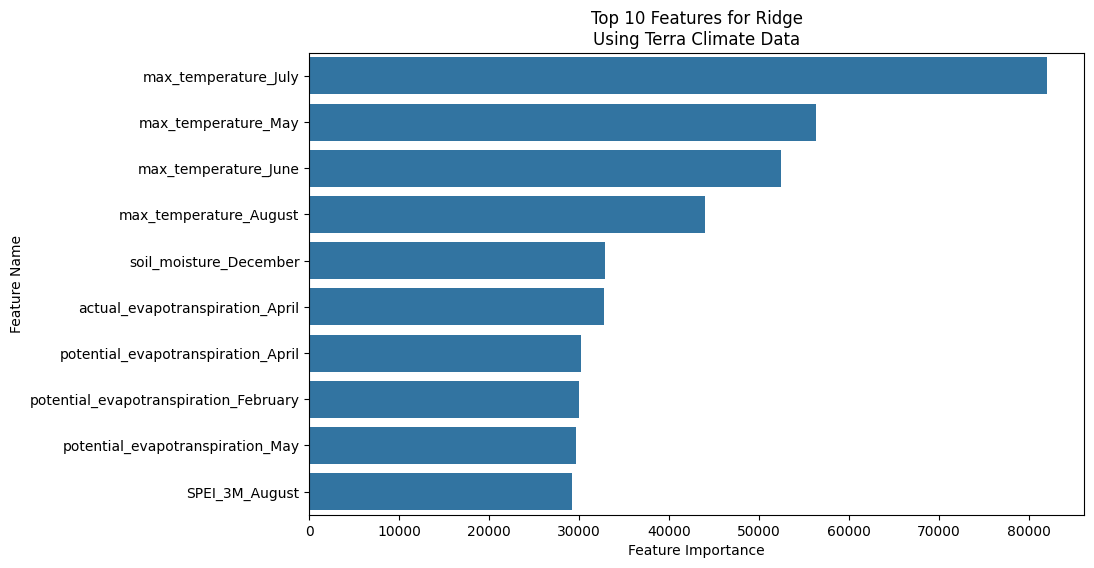

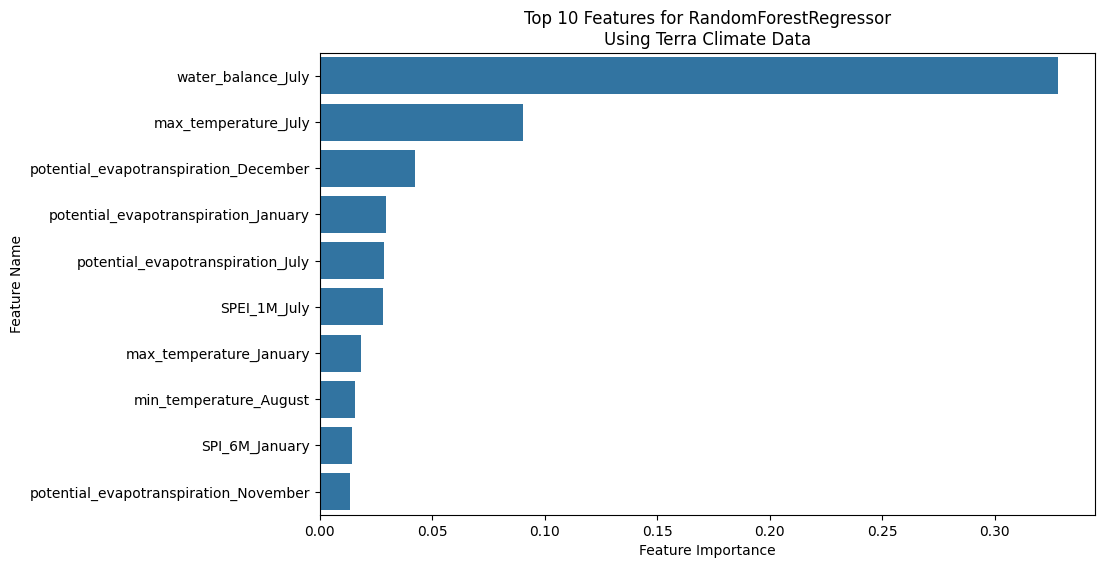

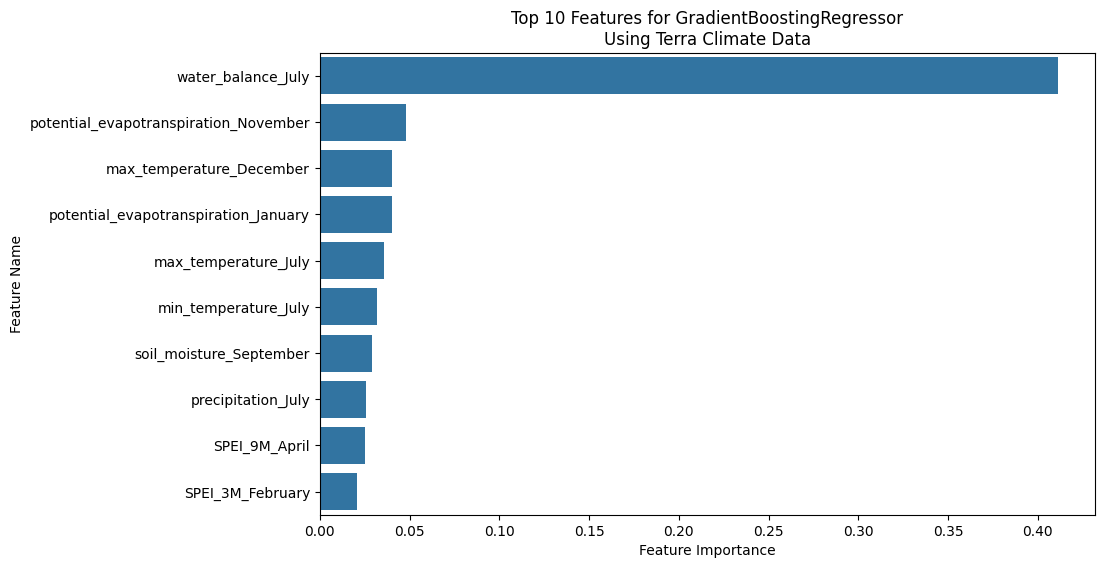

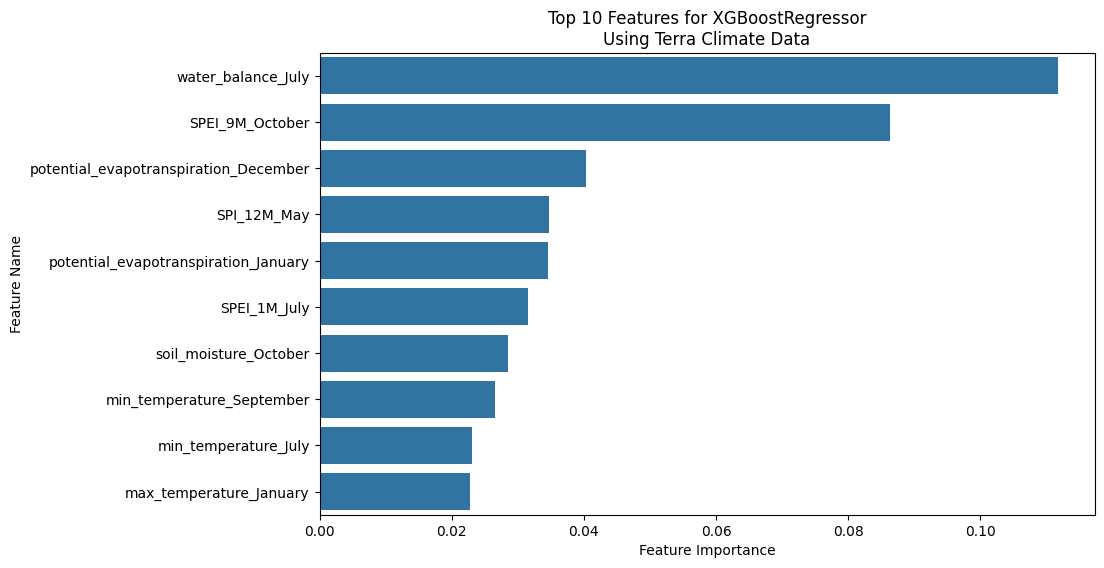

In [59]:
models_feature_importance_df_list = []

for model_name in good_models:
    best_pipeline = experiment_results[model_name].best_estimator_
    feature_names = get_feature_names(best_pipeline)
    coefficients_or_importances = get_model_coefficients_or_importances(
        best_pipeline.named_steps["model"]
    )

    if coefficients_or_importances is not None:
        model_feature_importance = (
            pd.DataFrame(
                {
                    "feature_name": feature_names,
                    "feature_importance": coefficients_or_importances.squeeze(),
                }
            )
            .sort_values(by="feature_importance", ascending=False)
            .head(10)
        )
        model_feature_importance["model_name"] = model_name
        models_feature_importance_df_list.append(model_feature_importance)

# Concatenate all results
models_feature_importance_df = pd.concat(
    models_feature_importance_df_list, ignore_index=True
)


for model in good_models:
    plt.figure(figsize=(10, 6))
    model_data = models_feature_importance_df[
        models_feature_importance_df["model_name"] == model
    ]
    sns.barplot(x="feature_importance", y="feature_name", data=model_data)
    plt.title(f"Top 10 Features for {model}\nUsing Terra Climate Data")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.show()

In [57]:
for model_name in good_models:
    model = experiment_results[model_name]
    model.best_estimator_.fit(X_train_tabular, y_train["total"])
    train_pred = model.best_estimator_.predict(X_train_tabular)
    test_pred = model.best_estimator_.predict(X_test_tabular)

    y_train[f"{model_name}_total"] = train_pred
    y_test[f"{model_name}_total"] = test_pred

true_vs_pred_df = pd.concat([y_train, y_test], axis=0).reset_index()

In [60]:
from sklearn.metrics import PredictionErrorDisplay

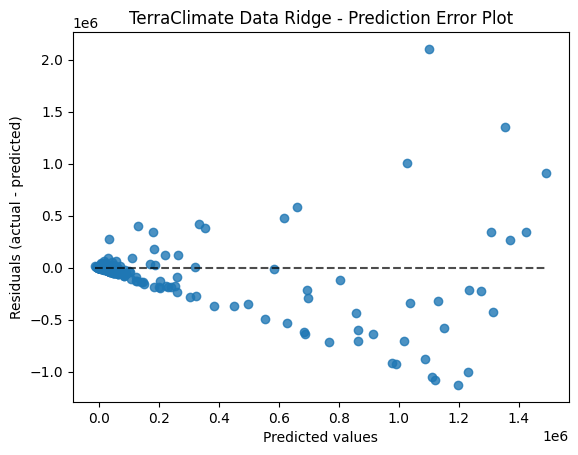

In [61]:
PredictionErrorDisplay.from_predictions(
    y_true=y_test["total"], y_pred=y_test["XGBoostRegressor_total"]
)
plt.title("TerraClimate Data Ridge - Prediction Error Plot")
plt.show()

In [62]:
from sktime.utils.plotting import plot_series

In [63]:
jaen_data = true_vs_pred_df.query("province == 'Jaén'").set_index("year")

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Jaén Olive Yield - True vs. Predicted\nTerraClimate XGBoost'}, ylabel='total'>)

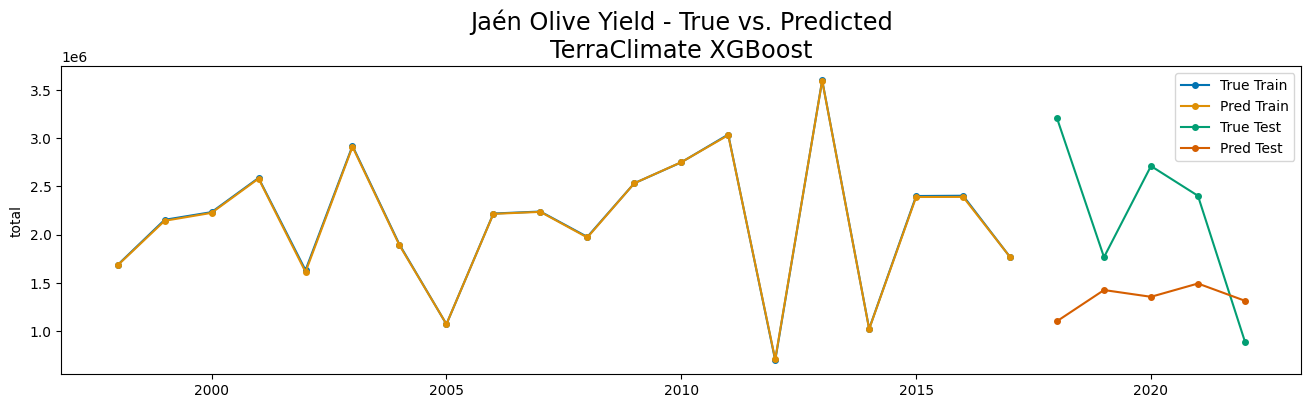

In [64]:
plot_series(
    jaen_data.loc[train_years, "total"],
    jaen_data.loc[train_years, "XGBoostRegressor_total"],
    jaen_data.loc[test_years, "total"],
    jaen_data.loc[test_years, "XGBoostRegressor_total"],
    labels=["True Train", "Pred Train", "True Test", "Pred Test"],
    title="Jaén Olive Yield - True vs. Predicted\nTerraClimate XGBoost",
)